# KATS Toolbox

This Notebook utilizes code (and text) from the KATS repository Notebook "Kats 101 - Basics", which is published under an MIT License.

In [1]:
# Main data packages. 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
# sys.path.append("../")

from kats.consts import TimeSeriesData

## Data

For input data we are converting the data based on the "imbalance_de.csv" data set (rebap) into a Pandas Dataframe:

In [2]:
rebap_df = pd.read_csv("data/PCA Data Sets/imbalance_de_labeled.csv")
rebap_df['dt_start_utc'] = rebap_df['dt_start_utc'].astype('datetime64')
rebap_df = rebap_df.drop(["power_mw"], axis=1)
rebap_df.columns = ["time", "value"]


## Visualize the raw data

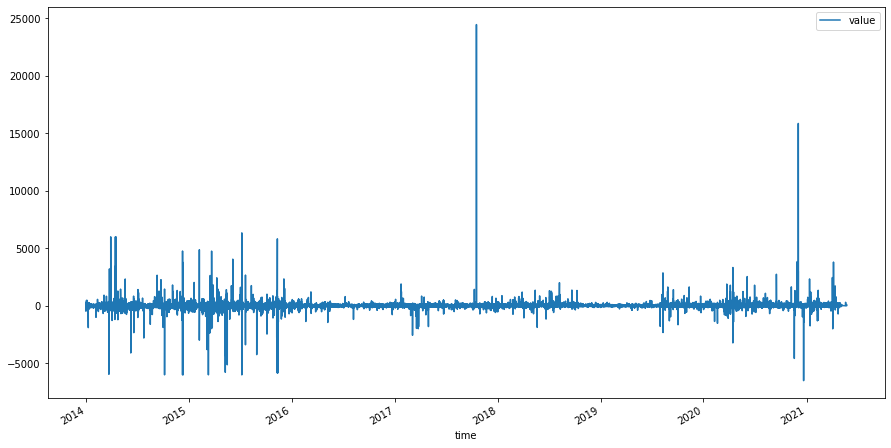

In [3]:
# visualize the raw  rebap data
rebap_df.plot(x='time', y='value', figsize=(15,8))
plt.show()

In [4]:
rebap_df.shape

(257010, 2)

### Filter out those rebap prizes that are not within 3 Standard deviations of the mean:

Now we will get rid of those outliers outside the +/- 3 Standard Deviation range with the following code line:

In [5]:
std_dev = 3*rebap_df['value'].std()
rebap_df = rebap_df[np.abs(rebap_df['value'] - rebap_df['value'].mean()) <= std_dev]

In [6]:
rebap_df.shape

(255840, 2)

In [7]:
rebap_ts = TimeSeriesData(rebap_df)

## Outlier detection

In [8]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(rebap_ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

In [9]:
ts_outlierDetection.outliers[0]

[Timestamp('2014-02-26 23:00:00'),
 Timestamp('2014-03-22 23:00:00'),
 Timestamp('2014-04-25 23:00:00'),
 Timestamp('2014-06-29 23:00:00'),
 Timestamp('2014-08-27 23:00:00'),
 Timestamp('2014-12-21 23:00:00'),
 Timestamp('2014-12-22 23:00:00'),
 Timestamp('2014-12-23 23:00:00'),
 Timestamp('2015-01-02 23:00:00'),
 Timestamp('2015-01-06 23:00:00'),
 Timestamp('2015-03-01 23:00:00'),
 Timestamp('2015-03-09 23:00:00'),
 Timestamp('2015-03-28 23:00:00'),
 Timestamp('2015-04-27 23:00:00'),
 Timestamp('2015-05-16 23:00:00'),
 Timestamp('2015-07-10 23:00:00'),
 Timestamp('2015-08-16 23:00:00'),
 Timestamp('2015-09-12 23:00:00'),
 Timestamp('2015-11-08 23:00:00'),
 Timestamp('2015-12-02 23:00:00'),
 Timestamp('2016-02-16 23:00:00'),
 Timestamp('2016-04-14 23:00:00'),
 Timestamp('2017-06-11 23:00:00'),
 Timestamp('2017-08-14 23:00:00'),
 Timestamp('2017-09-06 23:00:00'),
 Timestamp('2017-11-19 23:00:00'),
 Timestamp('2018-01-01 23:00:00'),
 Timestamp('2018-05-29 23:00:00'),
 Timestamp('2018-07-

After detecting the outlier, we can now easily remove them from the data. We will proceed
with Interpolation: outlier data points will be replaced with linear interploation values (without interpolation the Outliers would be replaced with NaN values)

In [10]:
rebap_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True)

Basic characteristics of the Data:

In [11]:
rebap_ts_outliers_interpolated.is_empty()

False

In [12]:
rebap_ts_outliers_interpolated.is_univariate()

True

## Forecasting with Prophet Model:

In [13]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(rebap_ts_outliers_interpolated, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 
fcst = m.predict(steps= 100, freq="MS")

Initial log joint probability = -6173.67
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99        394890     0.0435723       13855.3           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        395247     0.0208876       3456.78           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        395400    0.00213334       2673.04      0.2694           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        395455    0.00253901       2428.87      0.3052      0.3052      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        395496    0.00268541       722.395           1           1      601   
  

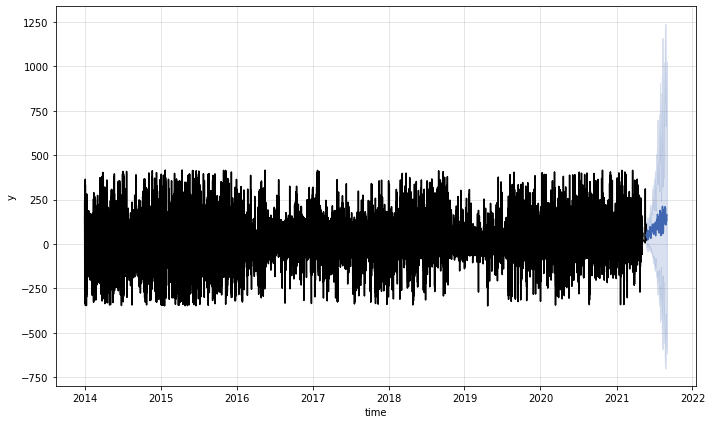

In [14]:
# visualize the results with uncertainty intervals
m.plot()

Prophet is unable to detect any meaningful trends or seasonality within the data set. Could it be that the imbalance price is more or less pure noise, without any detectable trend and seasonality?

## Theta Model

Excerpt from Kats 101 - Basics Notebook from KATS repository (published by facebook):

The Theta Method (Assimakopoulos and Nikolopoulos, 2000) is a univariate forecasting method that fits two Theta lines: 1) a linear interpolation (called the Theta=0) and 2) a second-order difference (called the Theta=2 line), and then combines them to build a forecast. Prior to running this forecast, we test the time series for seasonality, deseaonalize if seasonality is detected, and then reseasonalize the calculated forecasts.

Hyndman and Billah (2003) showed that the Theta Method is equivalent to simple exponential smoothing with drift. In Kats we use this underlying model to calculate prediction intervals for ThetaModel.

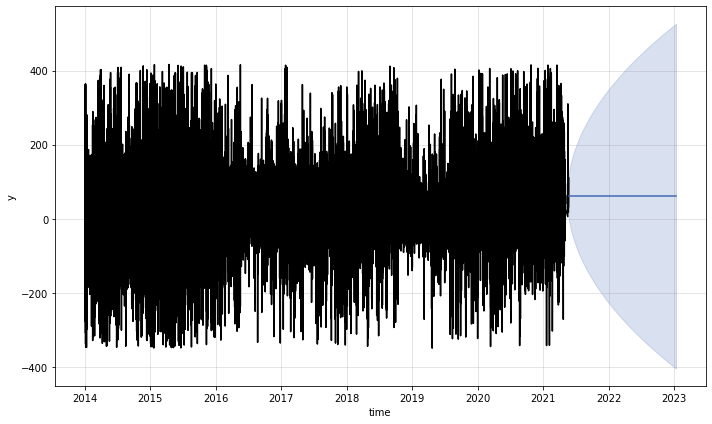

In [15]:
# import param and model from `kats.models.theta`
from kats.models.theta import ThetaModel, ThetaParams

# create ThetaParam with specifying seasonality param value
params = ThetaParams(m=1)

# create ThetaModel with given data and parameter class
m = ThetaModel(data=rebap_ts_outliers_interpolated, params=params)

# call fit method to fit model
m.fit()

# call predict method to predict the next 30 steps
res = m.predict(steps=600, alpha=0.2)

# visualize the results
m.plot()

## Feature Extraction with KATS

From the Notebook "Kats 101 - Basics" from Facebook´s GitHub Repository "KATS":

We provide the TsFeatures module to calculate a set of meaningful features for a time series, including:
- STL (Seasonal and Trend decomposition using Loess) Features
- Strength of Seasonality
- Strength of Trend
- Spikiness
- Linearity
- Amount of Level Shift
- Presence of Flat Segments
- ACF and PACF Features
- Hurst Exponent
- ARCH Statistic

Given a collection of time series, these features can be used to identify specific series that are similar or outlying. Our TsFeatures module is similar to the one that is freely available in R.

These features also play a crucial role in many downstream projects, including
- “Meta-learning”, i.e., choosing the best forecasting model based on characteristics of the input time series
- Time series classification and clustering analysis
- Nowcasting algorithms for better short-term forecasting


In [ ]:
# Initiate feature extraction class
from kats.tsfeatures.tsfeatures import TsFeatures
tsFeatures = TsFeatures()

In [ ]:
rebap_ts_features = TsFeatures().transform(rebap_ts_outliers_interpolated)

Feature Extraxtion NOT possible, Kernel dies repeatedly.

## Rocket Transform

In [13]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets.base import load_japanese_vowels  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket

## Dummy Data

In [49]:
X_train, y_train = load_japanese_vowels(split="train", return_X_y=True)

In [52]:
X_train.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11
0,0 1.860936 1 1.891651 2 1.939205 3...,0 -0.207383 1 -0.193249 2 -0.239664 3...,0 0.261557 1 0.235363 2 0.258561 3...,0 -0.214562 1 -0.249118 2 -0.291458 3...,0 -0.171253 1 -0.112890 2 -0.041053 3...,0 -0.118167 1 -0.112238 2 -0.102034 3...,0 -0.277557 1 -0.311997 2 -0.383300 3...,0 0.025668 1 -0.027122 2 0.019013 3...,0 0.126701 1 0.171457 2 0.169510 3...,0 -0.306756 1 -0.289431 2 -0.314894 3...,0 -0.213076 1 -0.247722 2 -0.227908 3...,0 0.088728 1 0.093011 2 0.074638 3...
1,0 1.303905 1 1.288280 2 1.332021 3...,0 0.067256 1 0.018672 2 -0.058744 3...,0 0.597720 1 0.631579 2 0.601928 3...,0 -0.271474 1 -0.355112 2 -0.347913 3...,0 -0.236808 1 -0.119216 2 -0.053463 3...,0 -0.411125 1 -0.434425 2 -0.421753 3...,0 -0.014826 1 -0.078036 2 -0.028479 3...,0 0.113175 1 0.178121 2 0.145073 3...,0 -0.058230 1 -0.106430 2 -0.159488 3...,0 -0.173138 1 -0.181910 2 -0.127751 3...,0 0.093058 1 0.093031 2 0.019092 3...,0 0.099247 1 0.099183 2 0.113546 3...
2,0 1.462484 1 1.309815 2 1.418207 3...,0 0.174066 1 0.120183 2 0.015721 3...,0 0.505133 1 0.503046 2 0.589994 3...,0 -0.374302 1 -0.327562 2 -0.310586 3...,0 -0.362125 1 -0.356789 2 -0.477019 3...,0 -0.400335 1 -0.445498 2 -0.367101 3...,0 -0.137429 1 -0.060423 2 -0.120849 3...,0 -0.000830 1 -0.007899 2 0.066952 3...,0 0.053888 1 0.041605 2 -0.023859 3...,0 -0.237630 1 -0.231087 2 -0.224317 3...,0 0.120636 1 0.121053 2 0.175298 3...,0 0.193254 1 0.202386 2 0.156670 3...
3,0 1.160837 1 1.217979 2 1.234654 3...,0 0.078806 1 -0.043693 2 -0.107083 3...,0 0.237706 1 0.378571 2 0.504189 3...,0 -0.010878 1 -0.055125 2 -0.151549 3...,0 -0.393053 1 -0.399601 2 -0.409837 3...,0 -0.744686 1 -0.756213 2 -0.666554 3...,0 0.173073 1 0.189754 2 0.176855 3...,0 -0.012922 1 0.014265 2 0.024257 3...,0 -0.071948 1 -0.099093 2 -0.085188 3...,0 0.028707 1 0.038970 2 0.005654 3...,0 0.074820 1 0.049702 2 -0.007566 3...,0 0.146297 1 0.164537 2 0.168465 3...
4,0 1.665670 1 1.685376 2 1.541171 3...,0 -0.251224 1 -0.305126 2 -0.238987 3...,0 0.309710 1 0.339418 2 0.295073 3...,0 -0.371666 1 -0.455499 2 -0.447638 3...,0 -0.311727 1 -0.259315 2 -0.200163 3...,0 -0.520932 1 -0.502600 2 -0.495071 3...,0 -0.215930 1 -0.195365 2 -0.189373 3...,0 0.255584 1 0.185427 2 0.123212 3...,0 0.048732 1 0.076114 2 0.130086 3...,0 -0.115333 1 -0.106838 2 -0.125721 3...,0 0.063014 1 -0.036998 2 -0.100226 3...,0 0.156787 1 0.200715 2 0.232676 3...


In [51]:
X_train.iloc[1,0]

0     1.303905
1     1.288280
2     1.332021
3     1.436550
4     1.510069
5     1.492324
6     1.731416
7     1.655716
8     1.560145
9     1.981364
10    1.640630
11    1.591455
12    1.582411
13    1.541301
14    1.592347
15    1.674087
16    1.681482
17    1.647909
18    1.570202
19    1.612420
20    1.589158
21    1.519606
22    1.452399
23    1.370862
24    1.307289
25    1.334578
26    0.000000
27    0.000000
28    0.000000
dtype: float64

## Data

For input data we are concentrating on those data sets which performed well with our PCA approach:

1. df_7
2. df_10_compact
3. df_11_compact
4. df_12_compact
5. df_13
6. df_14

Those DataFrames with "compact" in their names are based on other Dataframes BUT only contain those features which had at least some correlation with the target value "rebap_eur_mwh". This correaltion was identified via Seaborn correlation map. For reduced code lines we will simply import the stored csv-file of the ensemble_df:

In [14]:
df_7 = pd.read_csv("data/PCA Data Sets/EQ_epex_da_last_prognosis_count.csv")

In [15]:
df_7['timestamp']=df_7['timestamp'].astype('datetime64')

In [16]:
df_10 = pd.read_csv("data/PCA Data Sets/es_fc_total_renewables_ts.csv")

In [17]:
df_10['dt_start_utc']=df_10['dt_start_utc'].astype('datetime64')

In [18]:
df_10_compact = df_10[['dt_start_utc', "TTG_power_mw"]].copy()

In [19]:
df_11 = pd.read_csv("data/PCA Data Sets/es_fc_wind_offshore_ts.csv")

In [20]:
df_11['dt_start_utc']=df_11['dt_start_utc'].astype('datetime64')

In [21]:
df_11_compact = df_11[['dt_start_utc', "DE_power_mw", "TTG_power_mw"]].copy()

In [22]:
df_12 = pd.read_csv("data/PCA Data Sets/es_fc_wind_onshore_ts.csv")

In [23]:
df_12['dt_start_utc']=df_12['dt_start_utc'].astype('datetime64')

In [24]:
df_12_compact = df_12[['dt_start_utc', "50Hertz_power_mw", "DE_power_mw", "TTG_power_mw"]].copy()

In [25]:
df_13 = pd.read_csv("data/PCA Data Sets/wind_speed_ts.csv")

In [26]:
df_13['dt_start_utc']=df_13['dt_start_utc'].astype('datetime64')

In [27]:
df_14 = pd.read_csv("data/PCA Data Sets/imbalance_de_labeled.csv")

In [28]:
df_14['dt_start_utc']=df_14['dt_start_utc'].astype('datetime64')

In [29]:
df_14 = df_14.drop(["power_mw"], axis=1)

In [53]:
from apymb import *

df_rocket = align(df_7, df_10_compact, df_11_compact, df_12_compact, df_13, df_14)

In [54]:
df_rocket.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53610 entries, 2018-12-31 23:00:00 to 2020-07-12 09:15:00
Freq: 15T
Columns: 116 entries, 1_prognosis to 6_rebap_eur_mwh
dtypes: float64(116)
memory usage: 47.9 MB


## Filter out those rebap prizes that are not within 3 Standard deviations of the mean:

Now we will get rid of those rebap prize outliers outside the +/- 3 Standard Deviation range with the following code line:

In [55]:
std_dev = 3*df_rocket['6_rebap_eur_mwh'].std()
df_rocket = df_rocket[np.abs(df_rocket['6_rebap_eur_mwh'] - df_rocket['6_rebap_eur_mwh'].mean()) <= std_dev]

### Define new classification column named "rebap_price_class" in which the rebap price_range is translated to two classes:

- Class 0: Rebap prize below 0 €
- Class 1: Rebap prize above 0 €

In [56]:
df_rocket["rebap_price_class"] = np.nan
for i in range (len(df_rocket["rebap_price_class"])):
    if df_rocket["6_rebap_eur_mwh"][i] <= 0:
        df_rocket["rebap_price_class"][i] = 0
    else:
        df_rocket["rebap_price_class"][i]= 1
        
df_rocket["rebap_price_class"] = df_rocket["rebap_price_class"].astype('int')

In [57]:
df_rocket = df_rocket.drop(['6_rebap_eur_mwh'], axis= 1)

In [58]:
from sklearn.model_selection import train_test_split
X = df_rocket.drop(["rebap_price_class"],axis=1)
y = df_rocket["rebap_price_class"]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# balance the y classes to improve accuracy of the minority class detection:

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [62]:
X_train.to_numpy()

array([[4.66300000e+01, 2.12800000e+03, 2.16900000e+03, ...,
        4.97600000e+00, 4.72100000e+00, 3.81500000e+00],
       [3.15000000e+01, 9.24900000e+03, 4.83400000e+03, ...,
        1.29730000e+01, 0.00000000e+00, 1.36540000e+01],
       [1.98000000e+01, 0.00000000e+00, 2.03800000e+03, ...,
        4.46800000e+00, 5.92600000e+00, 5.56000000e+00],
       ...,
       [1.04787844e+01, 5.28977059e+03, 5.84602875e+03, ...,
        7.66452091e+00, 9.36139872e+00, 8.75563595e+00],
       [1.60697670e+01, 2.67245196e+03, 3.17843195e+03, ...,
        5.35876452e+00, 6.99244254e+00, 5.73243990e+00],
       [1.39104616e+01, 1.13715273e+04, 5.19194909e+03, ...,
        1.27056221e+01, 1.34874990e+01, 1.29376440e+01]])

Now, initialise ROCKET, Transform the Training Data:

In [63]:
rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.fit_transform(X_train)

ValueError: If passed as a pd.DataFrame, X must be a nested pd.DataFrame, with pd.Series or np.arrays inside cells.